# Pluralistic Approach to Decoding Motor Activity from Different Regions in the Rodent Brain
##### Project Contributors: Narotam Singh, Vaibhav, Rishika Mohanta, Prakriti Nayak

##### Done as part of [Neuromatch Academy](https://github.com/NeuromatchAcademy/course-content) July 13-31 2020

## Population Spike Code Approach Pipeline

The original data is from Steinmetz, Nicholas A., et al. "Distributed coding of choice, action and engagement across the mouse brain." Nature 576.7786 (2019): 266-273. It was then further cleaned to consider only recordings from motor related areas with more than 50 neurons from atleast 2 mice. We only considered the the open loop condition ie. data between stimulus onset and go cue to avoid representations of moving stimulus from appearing in the neural data we are analysing. 

Here we analyse the data generated from the GLM Pipeline

### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

### Import Dataset

In [2]:
alldat = np.load('../cleaned_dataset/train.npz',allow_pickle=True)['arr_0']

## Analysis of Dataset

First, lets quantify the number of mice, brain areas, sessions, trials, and neurons we have.

In [3]:
## Initialize dictionary
areas = {}
for i in set(np.concatenate([np.unique(i['brain_area']) for i in alldat])):
    areas[i] = {'session_count':0,'mice':[],'neuron_count':0,'trial_count':0}

## Fill dictionary with data
for i in alldat:
    for j in np.unique(i['brain_area']):
        areas[j]['neuron_count'] += sum(i['brain_area']==j)        
        areas[j]['session_count'] +=1
        areas[j]['trial_count'] +=i['spks'].shape[1]
        if i['mouse_name'] not in areas[j]['mice']: 
            areas[j]['mice'].append(i['mouse_name'])

# Print output
for i in areas:
    print(f"{i:4s} : {areas[i]['session_count']:2d} Sessions, {len(areas[i]['mice'])} Mice, {areas[i]['neuron_count']:4d} Neurons, {areas[i]['trial_count']:4d} Trials")

MD   :  3 Sessions, 3 Mice,  397 Neurons,  641 Trials
SNr  :  2 Sessions, 2 Mice,  246 Neurons,  446 Trials
SCm  :  3 Sessions, 2 Mice,  199 Neurons,  564 Trials
CP   :  5 Sessions, 5 Mice, 1215 Neurons,  993 Trials
VPL  :  3 Sessions, 2 Mice,  251 Neurons,  706 Trials
VPM  :  3 Sessions, 2 Mice,  322 Neurons,  623 Trials
MOp  :  3 Sessions, 3 Mice,  793 Neurons,  480 Trials
SCig :  4 Sessions, 2 Mice,  807 Neurons,  621 Trials
MOs  : 12 Sessions, 9 Mice, 1548 Neurons, 2535 Trials
SSp  :  2 Sessions, 2 Mice,  441 Neurons,  203 Trials


Secondly, lets look at the distribution of motor output (```wheel```) across different trials in all sessions 

In [4]:
motor_output_bins = np.arange(-20,21,1)
histograms = []
for i in alldat:
    for n,j in enumerate(i['wheel'][0]):
        start = int(i["stim_onset"]/i["bin_size"])
        end = int((i["stim_onset"]+i["gocue"][n])/i["bin_size"])
        histograms.append(np.histogram(j[start:end],bins=motor_output_bins)[0])

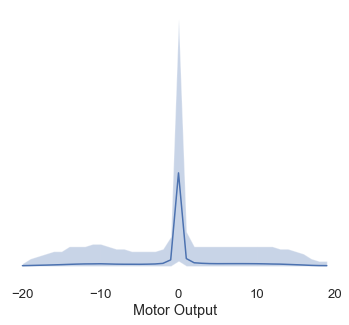

In [5]:
plt.figure(figsize=(6,5))
sns.set(font_scale=1.2)
plt.plot(motor_output_bins[:-1],np.array(histograms).mean(axis=0))
plt.fill_between(motor_output_bins[:-1],
                np.quantile(np.array(histograms),0.025,axis=0),
                np.quantile(np.array(histograms),0.975,axis=0),
                alpha=0.3)
plt.box(False)
plt.gca().set_yticklabels([])
plt.gca().set_yticks([])
plt.xlabel("Motor Output")
plt.show()

## Analysis of GLM pipeline results

In [6]:
df = pd.read_csv('../results/result.csv')
df.head()

,#Session_Number,Brain_Areas,Optimal_d,#Neurons_Used,Train_index,Test_index,Model,Correlation_Coefficient,R2_score
0,0,MOs,25,"[array([ 8, 70, 38, 75, 71, 77, 78, 28...","[array([ 40, 58, 124, 89, 110, 65, 131, 91...","[array([138, 115, 2, 154, 39, 160, 1, 90...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.723068,0.521490
1,0,MOs,25,"[array([ 32, 4, 15, 41, 76, 21, 9, 43...","[array([ 66, 49, 130, 122, 96, 87, 117, 30...","[array([ 83, 164, 14, 104, 139, 106, 0, 18...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.462945,0.168526
2,0,MOs,23,"[array([ 66, 27, 8, 60, 39, 24, 69, 7...","[array([ 11, 165, 161, 97, 90, 154, 136, 129...","[array([164, 127, 131, 107, 79, 138, 152, 69...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.760006,0.571846
3,0,MOs,1,"[array([ 52, 40, 85, 58, 12, 100, 19, 46...","[array([ 98, 152, 61, 4, 1, 146, 141, 22...","[array([ 39, 154, 147, 170, 26, 142, 66, 90...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.152956,-0.045675
4,0,MOs,13,"[array([ 43, 95, 94, 65, 38, 34, 32, 14...","[array([ 42, 113, 130, 171, 28, 98, 81, 36...","[array([121, 88, 30, 89, 101, 19, 25, 124...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.581724,0.325712


### Analysis of R2 and Correlation Coefficient

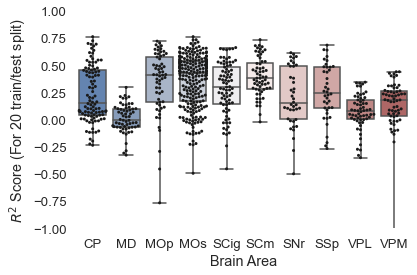

In [7]:
sns.set(font_scale=1.2)
plt.gca().set_ylim((-1,1))
sns.boxplot(x='Brain_Areas',y='R2_score',data=df,whis=[0, 100], palette="vlag", order=np.unique(df.Brain_Areas))
sns.swarmplot(x='Brain_Areas',y='R2_score',data=df, size=3, color="k", linewidth=0, order=np.unique(df.Brain_Areas))
plt.box(False)
plt.ylabel(r'$R^2$ Score (For 20 train/test split)')
plt.xlabel('Brain Area')
plt.show()

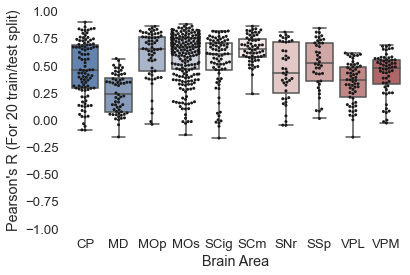

In [8]:
sns.set(font_scale=1.2)
plt.gca().set_ylim((-1,1))
sns.boxplot(x='Brain_Areas',y='Correlation_Coefficient',data=df,whis=[0, 100], palette="vlag", order=np.unique(df.Brain_Areas))
sns.swarmplot(x='Brain_Areas',y='Correlation_Coefficient',data=df, size=3, color="k", linewidth=0, order=np.unique(df.Brain_Areas))
plt.box(False)
plt.ylabel("Pearson's R (For 20 train/test split)")
plt.xlabel('Brain Area')
plt.show()

#### Correlation between R2 and Correlation Analysis

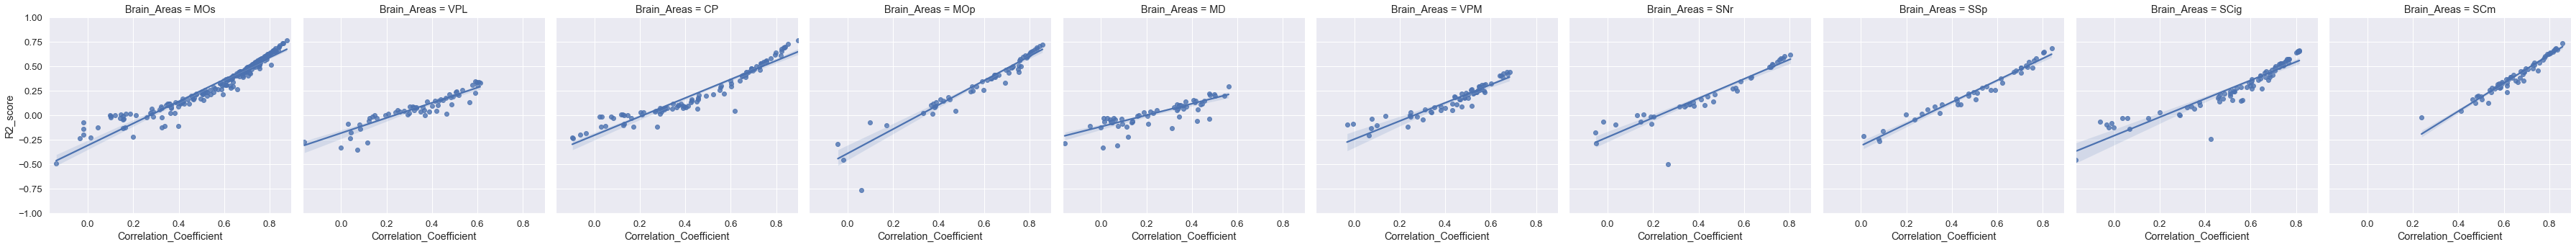

In [9]:
g = sns.lmplot('Correlation_Coefficient','R2_score',data=df,col='Brain_Areas',robust=True)
g.set(ylim=(-1,1))

### Analysis of Optimal Temporal History

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


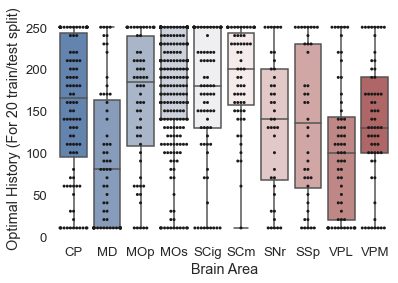

In [12]:
sns.set(font_scale=1.2)
plt.gca().set_ylim((0,26))
sns.boxplot(x='Brain_Areas',y='Optimal_d',data=df,whis=[0, 100], palette="vlag", order=np.unique(df.Brain_Areas))
sns.swarmplot(x='Brain_Areas',y='Optimal_d',data=df, size=3, color="k", linewidth=0, order=np.unique(df.Brain_Areas))
plt.box(False)
plt.ylabel("Optimal History (For 20 train/test split)")
plt.xlabel('Brain Area')
plt.gca().set_yticklabels([0,50,100,150,200,250])
plt.show()

The optimal kernel size seems to be variable for different brain regions.